In [2]:
import mmf_setup;mmf_setup.nbinit(hgroot=False)

<IPython.core.display.Javascript object>

# Performance

Several places in our code need high performance.  Here we discuss some options.

# Integration

Consider computing the total particle number as a function of $\mu_a$, $\mu_b$, $\Delta$, $t$, $m$, and $\hbar$.  This requires the following integral:

$$
  n_+ = \int\frac{d^d{k}}{(2\pi)^d}\; \left(1 - \frac{\epsilon_+}{E}[f(\omega_-) - f(\omega_+)]\right), \qquad
  f(E) = \frac{1}{1+e^{E/T}}, \qquad
  \omega_{\pm} = \epsilon_- \pm E, \\
  E = \sqrt{\epsilon_+^2 + \abs{\Delta}^2}, \qquad
  \epsilon_{a, b} = \frac{\hbar^2k^2}{2m} - \mu_{a, b}, \qquad 
  \epsilon_{\pm} = \frac{\epsilon_{a} \pm \epsilon_{b}}{2}.
$$

In [3]:
from scipy.integrate import quad
import numpy as np
from uncertainties import ufloat

def f(E, T):
    """Fermi distribution function."""
    if T == 0:
        return (1 - np.sign(E))/2
    else:
        return 1./(1+np.exp(E/T))


def n_integrand(k, mu_a, mu_b, delta, m_a, m_b, hbar, T):
    e = (hbar*k)**2/2
    e_a, e_b = e/m_a - mu_a, e/m_b - mu_b
    e_m, e_p = (e_a -e_b)/2, (e_a + e_b)/2
    E = np.sqrt(e_p**2 + abs(delta)**2)
    w_m, w_p = e_m - E, e_m + E
    return 1 - e_p/E*(f(w_m, T)- f(w_p, T))


# Test BdG at unitary point.
m = hbar = kF = 1.0
eF = (hbar*kF)**2/2/m
nF = kF**3/3/np.pi**2
mu_a = mu_b = 0.59060550703283853378393810185221521748413488992993*eF
delta = 0.68640205206984016444108204356564421137062514068346*eF

def integrand(k):
    return n_integrand(k, mu_a, mu_b, delta, m, m, hbar, T=0.0) * k**2/2/np.pi**2

%timeit n = ufloat(*quad(integrand, 0, kF)) + ufloat(*quad(integrand, kF, np.inf))
n = ufloat(*quad(integrand, 0, kF)) + ufloat(*quad(integrand, kF, np.inf))
n - nF

765 µs ± 2.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


-1.0620246765347119e-09+/-4.378828833166519e-09

Our first attempt to improve performance is to use the numba just-in-time (JIT) compiler.

In [5]:
import numba

@numba.jit(nopython=True)
def f(E, T):
    """Fermi distribution function."""
    if T == 0:
        return (1 - np.sign(E))/2
    else:
        return 1./(1+np.exp(E/T))

@numba.jit(nopython=True)
def n_integrand(k, mu_a, mu_b, delta, m_a, m_b, hbar, T):
    e = (hbar*k)**2/2
    e_a, e_b = e/m_a - mu_a, e/m_b - mu_b
    e_m, e_p = (e_a -e_b)/2, (e_a + e_b)/2
    E = np.sqrt(e_p**2 + abs(delta)**2)
    w_m, w_p = e_m - E, e_m + E
    return 1 - e_p/E*(f(w_m, T)- f(w_p, T))

@numba.jit(nopython=True)
def integrand(k):
    return n_integrand(k, mu_a, mu_b, delta, m, m, hbar, 0.0) * k**2/2/np.pi**2

%timeit n = ufloat(*quad(integrand, 0, kF)) + ufloat(*quad(integrand, kF, np.inf))
n = ufloat(*quad(integrand, 0, kF)) + ufloat(*quad(integrand, kF, np.inf))
n - nF

43.7 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


-1.0620246765347119e-09+/-4.378828833166519e-09

Populating the interactive namespace from numpy and matplotlib


c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


1.6522295319699407

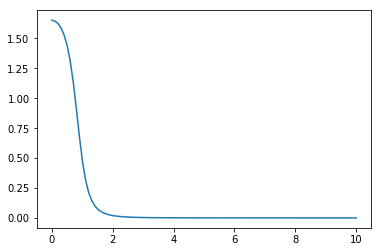

In [6]:
k = np.linspace(0, 10, 100)
%pylab inline
plt.plot(k, [n_integrand(k_, mu_a, mu_b, delta, m, m, hbar, 0.0) for k_ in k])
n_integrand(0, mu_a, mu_b, delta, m, m, hbar, 0.0)

This can be improved a bit by wrapping this in scipy's [LowLevelCallable](https://docs.scipy.org/doc/scipy/reference/generated/scipy.LowLevelCallable.html#scipy.LowLevelCallable) routine:

In [7]:
import scipy
args = (mu_a, mu_b, delta, m, m, hbar, 0.0)

@numba.cfunc(numba.float64(numba.float64))
def integrand(k):
    return n_integrand(k, *args) * k**2/2/np.pi**2
    #return n_integrand(k, mu_a, mu_b, delta, m, m, hbar, 0.0) * k**2/2/np.pi**2
integrand = scipy.LowLevelCallable(integrand.ctypes)

%timeit quad(integrand, 0, kF)[0] + quad(integrand, kF, np.inf)[0]
%timeit n = ufloat(*quad(integrand, 0, kF)) + ufloat(*quad(integrand, kF, np.inf))
n = ufloat(*quad(integrand, 0, kF)) + ufloat(*quad(integrand, kF, np.inf))
n - nF

9.53 µs ± 65.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
24.8 µs ± 186 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


-1.0620246765347119e-09+/-4.378828833166519e-09

In [8]:
import math
import scipy.special
import scipy as sp
@numba.cfunc(numba.float64(numba.float64))
def integrand(k):
    return 2*math.exp(-k**2/2)/math.sqrt(2*np.pi)
integrand = scipy.LowLevelCallable(integrand.ctypes)

assert np.allclose(quad(integrand, 0, 10)[0], sp.special.erf(100) - sp.special.erf(0))

%timeit quad(lambda x:math.exp(-x**2), 0, 10)
%timeit quad(integrand, 0, 10)
%timeit sp.special.erf(10) - sp.special.erf(0)

49.2 µs ± 230 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.1 µs ± 13.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.63 µs ± 11.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
import numexpr
k = np.linspace(0,10,100)
%timeit np.trapz(np.exp(-k**2/2)/np.sqrt(np.pi/2), k)
pi = np.pi
%timeit np.trapz(numexpr.evaluate('exp(-k**2/2)/sqrt(pi/2)'), k)

33.2 µs ± 1.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
55.7 µs ± 2.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
